# Labeled Convolutional VAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'vae.conv.labels'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 75
LR = 4e-04
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222
hidden_dims = (128, 64, 32)
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

model = M.vae.LabeledConvVAE(input_dim, hidden_dims, latent_dim, classes_dim)
criterion = M.vae.Loss()

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)


INFO | model: pallets.models.vae.LabeledConvVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.0004
INFO | epochs: 75


INFO | epoch 1 (  0%) loss: 1419197.750000
INFO | epoch 1 ( 35%) loss: 122529.900526
INFO | epoch 1 ( 70%) loss: 69372.338459
INFO | epoch 1 (100%) loss: 53467.616245
INFO | epoch 1 (test) loss: 13414.492668
INFO | epoch 2 (  0%) loss: 13545.669922
INFO | epoch 2 ( 35%) loss: 13571.447904
INFO | epoch 2 ( 70%) loss: 13352.319584
INFO | epoch 2 (100%) loss: 13152.232237
INFO | epoch 2 (test) loss: 12140.594719
INFO | epoch 3 (  0%) loss: 11306.464844
INFO | epoch 3 ( 35%) loss: 12233.853342
INFO | epoch 3 ( 70%) loss: 12009.985954
INFO | epoch 3 (100%) loss: 11850.466509
INFO | epoch 3 (test) loss: 11101.020920
INFO | epoch 4 (  0%) loss: 12077.274414
INFO | epoch 4 ( 35%) loss: 11279.159305
INFO | epoch 4 ( 70%) loss: 11175.087206
INFO | epoch 4 (100%) loss: 10982.792820
INFO | epoch 4 (test) loss: 10158.019402
INFO | epoch 5 (  0%) loss: 11190.876953
INFO | epoch 5 ( 35%) loss: 10240.226417
INFO | epoch 5 ( 70%) loss: 9978.873776
INFO | epoch 5 (100%) loss: 9760.041904
INFO | epoch 5 

# Results

torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


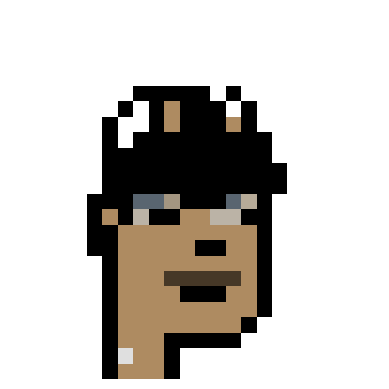

In [9]:

z = torch.randn(1, latent_dim).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)

decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


In [10]:
import random

label_idx = int(random.random() * len(dataset))
_, features = dataset[label_idx]

enabled_features = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['male', 'purpleHair', 'vape', 'smallShades']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


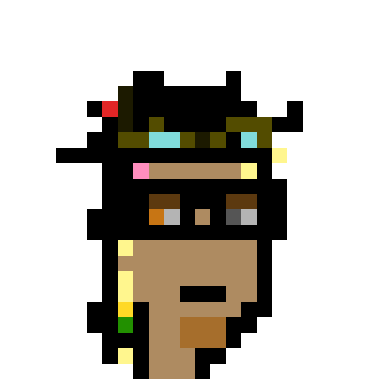

In [11]:
# Generate new image

z = torch.randn(1, latent_dim).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)

decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


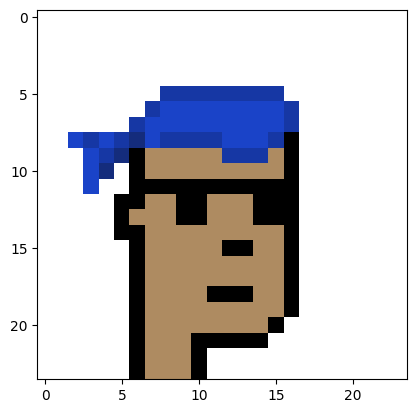

In [12]:
# punk = I.get_punk_tensor(1000)
punk, punk_labels = dataset[4000]
punk = DS.one_hot_to_rgba(punk, dataset.mapper)

plt.imshow(transforms.functional.to_pil_image(punk))
plt.show()



torch.Size([1, 222, 24, 24])


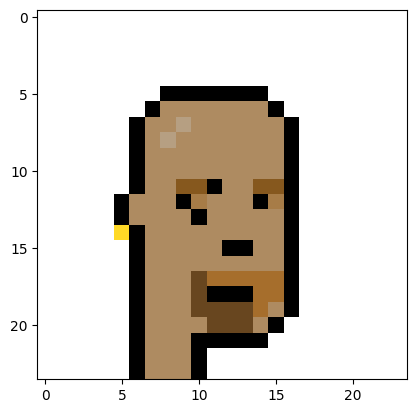

In [13]:
punk, punk_labels = dataset[4000]

punk_labels = punk_labels.unsqueeze(0).to(device)

# punk = I.get_punk_tensor(1000)

p = DS.rgba_to_one_hot(punk, dataset.mapper)
p = p.unsqueeze(0)
p = p.to(device)

model.eval()
with torch.no_grad():
    reconstructed, mu, logcar = model.forward(p, punk_labels)
    print(reconstructed.shape)

recon_punk = reconstructed[0].cpu()
recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)
plt.imshow(transforms.functional.to_pil_image(recon_punk.cpu()))
plt.show()


## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

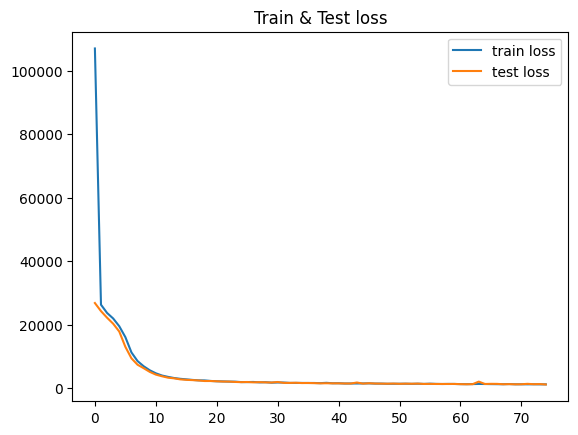

In [14]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [15]:
train_losses


[106935.23248940326,
 26304.464474941822,
 23700.93301889406,
 21965.585639683068,
 19520.083807762632,
 16100.613489895002,
 11281.72445007757,
 8565.194784827267,
 6939.354741089733,
 5668.068396169243,
 4717.135549342379,
 4017.1197574696644,
 3587.197068667581,
 3228.949392115816,
 2980.26487309882,
 2808.1265804209606,
 2633.040562839373,
 2498.4747069879627,
 2473.2758830185476,
 2306.2184002382537,
 2204.4017717077377,
 2158.7642374241605,
 2102.5994891443997,
 2078.4839992658467,
 1950.8116284093112,
 1950.4357719691932,
 1988.2392811876662,
 1857.0558643746883,
 1906.7280721461518,
 1770.9608390212904,
 1825.203092967365,
 1805.4802624858019,
 1686.7460963472406,
 1694.807456699669,
 1681.6076542198234,
 1669.8656514485676,
 1666.6237873050338,
 1615.2772030661292,
 1716.744474695084,
 1577.3888854980469,
 1591.5287445284796,
 1500.6959282624807,
 1506.3081471328194,
 1510.5010005869765,
 1519.3512643584122,
 1545.4453003795434,
 1475.6825938123338,
 1470.3328286028923,
 1413.

In [16]:
test_losses


[26828.98533630371,
 24281.18943786621,
 22202.04183959961,
 20316.038803100586,
 17857.14924621582,
 13048.337051391602,
 9425.658599853516,
 7409.475006103516,
 6325.882614135742,
 5165.752410888672,
 4305.979415893555,
 3787.537528991699,
 3337.28733253479,
 3131.5363540649414,
 2806.694610595703,
 2658.872652053833,
 2575.600715637207,
 2465.722324371338,
 2285.9619884490967,
 2284.628490447998,
 2205.3243370056152,
 2117.8907508850098,
 2106.6175594329834,
 1998.010754585266,
 1929.674810409546,
 1971.0591049194336,
 1872.4960050582886,
 1926.6109027862549,
 1858.3890171051025,
 1812.7856636047363,
 1975.260124206543,
 1700.5894899368286,
 1694.7202682495117,
 1730.2541189193726,
 1646.2873764038086,
 1662.6181373596191,
 1622.8672647476196,
 1562.2968521118164,
 1582.2748317718506,
 1557.1399755477905,
 1551.691418647766,
 1508.7248277664185,
 1496.8745794296265,
 1808.6113510131836,
 1472.3529052734375,
 1588.3711376190186,
 1489.8585786819458,
 1465.4598188400269,
 1438.7636957